<a href="https://colab.research.google.com/github/IsharaSilva/Prediction-Recommedation-system-for-Potato-Cultivation/blob/main/Main_Module.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import joblib
import numpy as np # dataAnalysis
import pandas as pd #multidimensional arrays
import matplotlib.pyplot as plt #data visualization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage import img_as_ubyte
from skimage.util import img_as_float

In [ ]:
import os
path = os.listdir('/content/drive/MyDrive/KP/')
classes = {'Colorado potato beetle': 0, 'Flea beetle': 1,'Early blight':2,'Late blight':3, 'healthy':4,'PSTV foliar symptoms':5,'Rugose mosaic symptom':6}

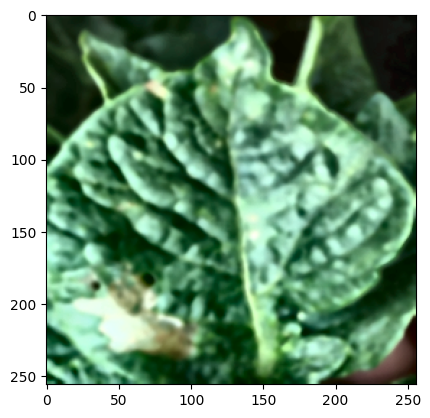

In [ ]:
import cv2
import os
import numpy as np

input_dir = '/content/drive/MyDrive/KP/'
output_dir = '/content/drive/MyDrive/KP/Preprocessed/'

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define the list of transformations
transformations = [
    ('rotation', cv2.ROTATE_90_CLOCKWISE),  # Rotate the image 90 degrees clockwise
    ('translation', np.float32([[1, 0, 50], [0, 1, 50]])),  # Translate the image by 50 pixels in both x and y directions
    ('scaling', np.float32([[0.5, 0, 0], [0, 0.5, 0]])),  # Scale down the image by 0.5
    ('flipping', 0),  # Flip the image horizontally
    #('noise', 30)  # Add Gaussian noise with mean=0 and standard deviation=30
]

x = []
y = []

for cls in classes:
    pth = os.path.join(input_dir, cls)
    for j in os.listdir(pth):
        img = cv2.imread(os.path.join(pth, j))
        img1 = cv2.resize(img, (256, 256))  # Image resizing
        img1 = cv2.medianBlur(img1, 5)  # Apply median filter to remove noise
        img1 = img_as_ubyte(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))  # Contrast improvement

        # Convert the image to LAB color space
        img1_lab = cv2.cvtColor(img1, cv2.COLOR_RGB2LAB)

        # Split the LAB image into separate channels
        img1_lab_planes = cv2.split(img1_lab)

        # Apply histogram equalization to the L channel
        img1_lab_planes = list(img1_lab_planes)
        img1_lab_planes[0] = cv2.equalizeHist(img1_lab_planes[0])
        img1_lab_planes = tuple(img1_lab_planes)

        # Merge the planes and convert back to RGB
        img1_lab = cv2.merge(img1_lab_planes)
        img1 = cv2.cvtColor(img1_lab, cv2.COLOR_LAB2RGB)

        # Smoothing
        img1 = cv2.GaussianBlur(img1, (5, 5), 0)

        # CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img1_lab_planes = cv2.split(cv2.cvtColor(img1, cv2.COLOR_RGB2LAB))
        img1_lab_planes = list(img1_lab_planes)
        img1_lab_planes[0] = clahe.apply(img1_lab_planes[0])
        img1_lab_planes = tuple(img1_lab_planes)
        img1_lab = cv2.merge(img1_lab_planes)
        img1 = cv2.cvtColor(img1_lab, cv2.COLOR_LAB2RGB)

        # Save preprocessed image
        output_path = os.path.join(output_dir, cls, j)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        cv2.imwrite(output_path, img1)

        # Append the preprocessed image and original image to the lists
        x.append(img1)
        y.append(img)

        # Apply transformations to the image
        for transform_name, transform_param in transformations:
            transformed_img = img1.copy()

            if transform_name == 'rotation':
                transformed_img = cv2.rotate(transformed_img, transform_param)
            elif transform_name == 'translation':
                M = transform_param
                transformed_img = cv2.warpAffine(transformed_img, M, (img1.shape[1], img1.shape[0]))
            elif transform_name == 'scaling':
                M = transform_param
                transformed_img = cv2.warpAffine(transformed_img, M, (int(img1.shape[1]*0.5), int(img1.shape[0]*0.5)))
            elif transform_name == 'flipping':
                transformed_img = cv2.flip(transformed_img, transform_param)
            #elif transform_name == 'noise':
                #noise = np.random.normal(0, transform_param, img1.shape).astype(np.uint8)
                #transformed_img = cv2.add(transformed_img, noise)

            # Save the transformed image
            output_path = os.path.join(output_dir, cls, f'{transform_name}_{j}')
            cv2.imwrite(output_path, transformed_img)

# Display the preprocessed image
plt.imshow(x[0])


In [26]:
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy
import cv2
import os

preprocessed_dir = '/content/drive/MyDrive/KP/Preprocessed/'
features = []
labels = []

# GLCM parameters
distances = [1]
angles = [0]

for cls in classes:
    pth = os.path.join(preprocessed_dir, cls)
    for j in os.listdir(pth):
        img_path = os.path.join(pth, j)
        img = cv2.imread(img_path)

        # Split RGB image into channels
        blue, green, red = cv2.split(img)

        # Calculate mean and standard deviation for each channel
        mean_blue = blue.mean()
        mean_green = green.mean()
        mean_red = red.mean()
        std_dev_blue = blue.std()
        std_dev_green = green.std()
        std_dev_red = red.std()

        # Convert RGB image to HSV
        hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # Split HSV image into channels
        hue, saturation, value = cv2.split(hsv_img)

        # Calculate mean hue
        mean_hue = hue.mean()

        # Convert RGB image to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Compute GLCM
        glcm = greycomatrix(gray_img, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

        # Compute GLCM properties
        contrast = greycoprops(glcm, prop='contrast')[0, 0]
        dissimilarity = greycoprops(glcm, prop='dissimilarity')[0, 0]
        homogeneity = greycoprops(glcm, prop='homogeneity')[0, 0]
        correlation = greycoprops(glcm, prop='correlation')[0, 0]

        # Store the extracted features and labels
        feature = [
            contrast, dissimilarity, homogeneity, correlation, mean_hue,
            mean_red, mean_green, mean_blue, std_dev_red, std_dev_green, std_dev_blue
        ]
        features.append(feature)
        labels.append(cls)

print("Features Extracted Successfully!")


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1

Features Extracted Successfully!


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

In [27]:
import os
import joblib
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Convert the feature list and labels to numpy arrays
X = np.array(features)
y = np.array(labels)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Specify the file path to save the model
model_path = '/content/drive/MyDrive/KP/Main_model.pkl'

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Save the trained model to a file
joblib.dump(rf_classifier, model_path)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
classification_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report)


Accuracy: 0.9473409801876955
Classification Report:
                        precision    recall  f1-score   support

Colorado potato beetle       0.97      0.99      0.98       145
          Early blight       0.95      0.96      0.95       379
           Flea beetle       0.97      0.88      0.93       164
           Late blight       0.95      0.91      0.93       354
  PSTV foliar symptoms       0.93      0.96      0.95       380
 Rugose mosaic symptom       0.95      0.96      0.96       261
               healthy       0.93      0.96      0.95       235

              accuracy                           0.95      1918
             macro avg       0.95      0.95      0.95      1918
          weighted avg       0.95      0.95      0.95      1918



In [28]:
num_train_images = X_train.shape[0]
print("Number of images in the training dataset:", num_train_images)

num_test_images = X_test.shape[0]
print("Number of images in the testing dataset:", num_test_images)

Number of images in the training dataset: 7672
Number of images in the testing dataset: 1918


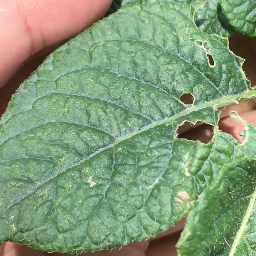

 Predicted Label:Colorado potato beetle


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


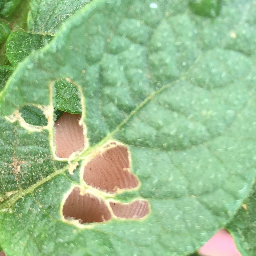

 Predicted Label:Colorado potato beetle


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


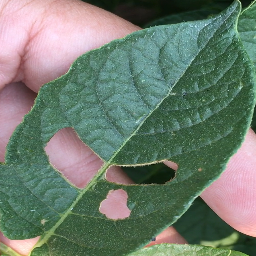

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


 Predicted Label:Flea beetle


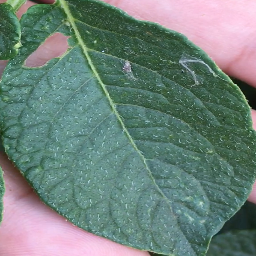

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


 Predicted Label:Flea beetle


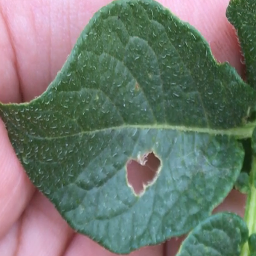

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


 Predicted Label:Flea beetle


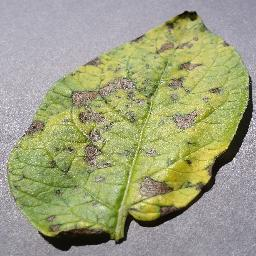

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


 Predicted Label:Early blight


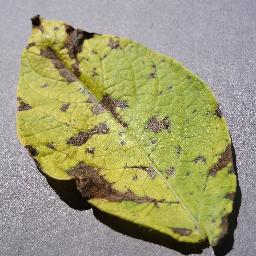

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


 Predicted Label:Early blight


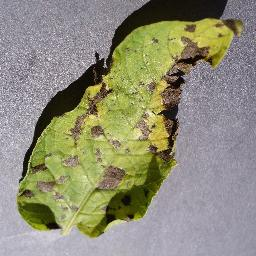

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


 Predicted Label:Early blight


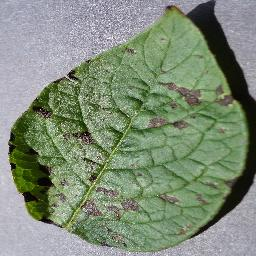

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


 Predicted Label:Early blight


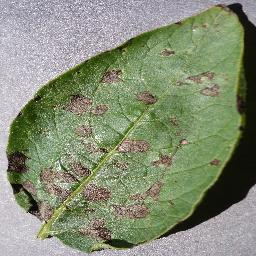

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


 Predicted Label:Early blight


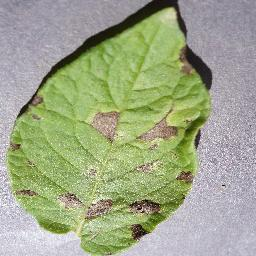

 Predicted Label:Early blight


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


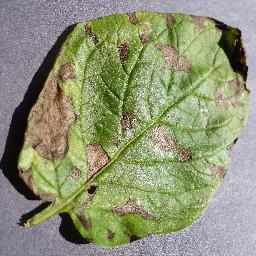

 Predicted Label:Early blight


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


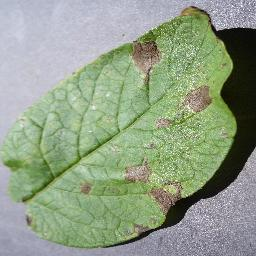

 Predicted Label:Early blight


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


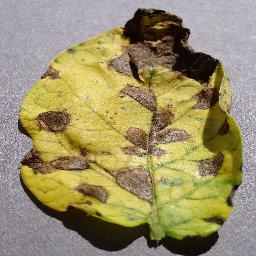

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


 Predicted Label:Early blight


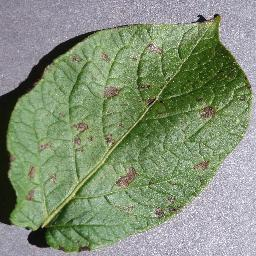

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


 Predicted Label:Early blight


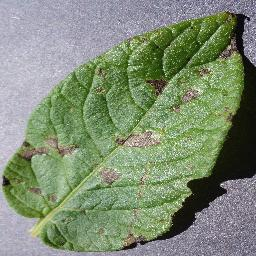

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


 Predicted Label:Early blight


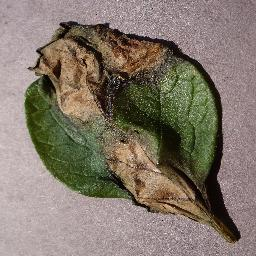

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


 Predicted Label:Late blight


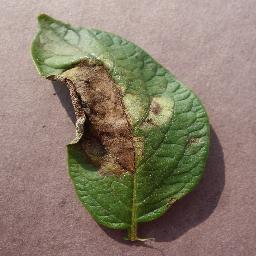

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


 Predicted Label:Late blight


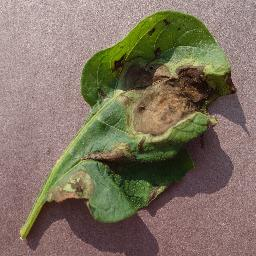

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


 Predicted Label:Late blight


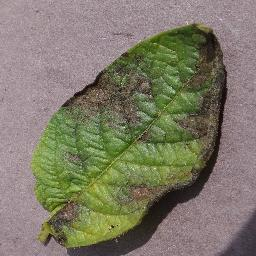

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


 Predicted Label:Late blight


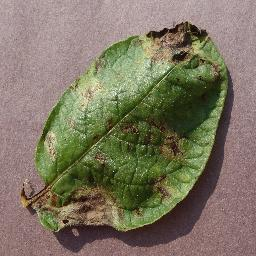

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


 Predicted Label:Late blight


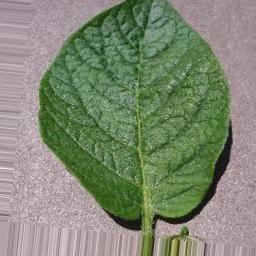

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


 Predicted Label:healthy


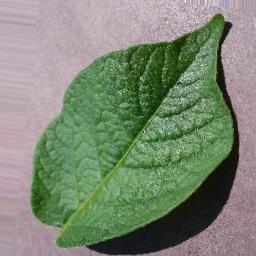

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


 Predicted Label:healthy


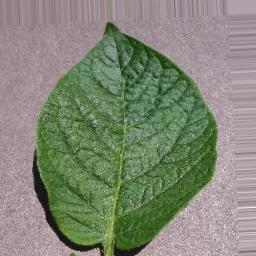

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


 Predicted Label:healthy


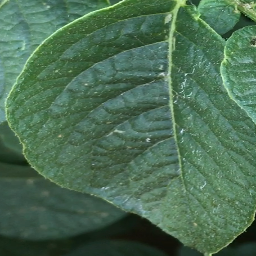

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


 Predicted Label:PSTV foliar symptoms


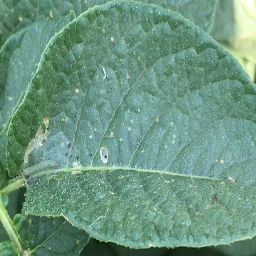

 Predicted Label:PSTV foliar symptoms


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


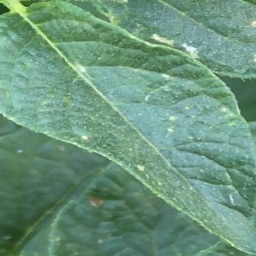

 Predicted Label:PSTV foliar symptoms


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


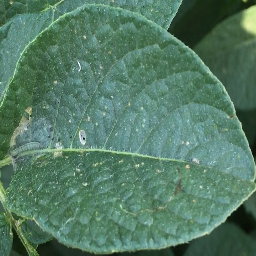

 Predicted Label:PSTV foliar symptoms


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


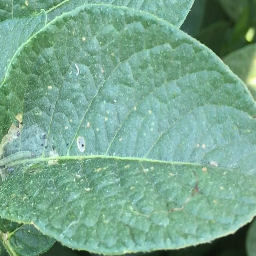

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


 Predicted Label:PSTV foliar symptoms


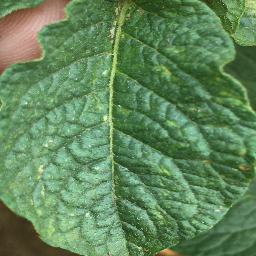

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


 Predicted Label:Rugose mosaic symptom


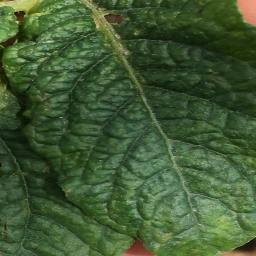

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


 Predicted Label:Rugose mosaic symptom


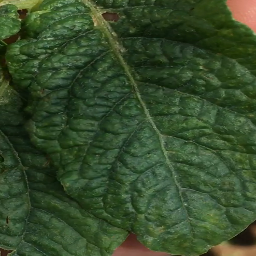

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


 Predicted Label:Rugose mosaic symptom


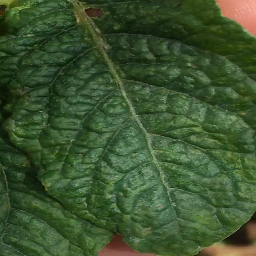

 Predicted Label:Rugose mosaic symptom


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


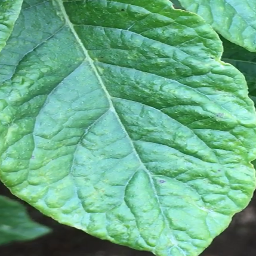

 Predicted Label:Rugose mosaic symptom


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


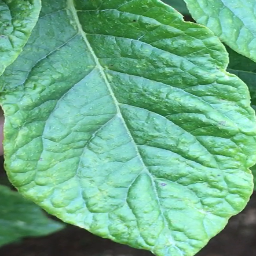

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


 Predicted Label:Rugose mosaic symptom


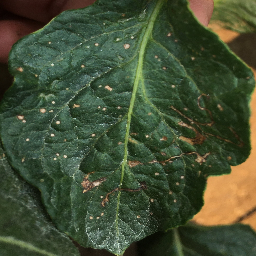

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


 Predicted Label:Rugose mosaic symptom


In [68]:
import cv2
import os
import joblib
import numpy as np
from skimage.feature import graycomatrix, greycoprops
from skimage.measure import shannon_entropy
from sklearn.metrics import accuracy_score, classification_report
from google.colab.patches import cv2_imshow

test_dir = '/content/drive/MyDrive/KP/Testing/'
model_path = '/content/drive/MyDrive/KP/Main_model.pkl'

classes = {
    'Colorado potato beetle': 0,
    'Flea beetle': 1,
    'Early blight': 2,
    'Late blight': 3,
    'healthy': 4,
    'PSTV foliar symptoms': 5,
    'Rugose mosaic symptom': 6
}

predicted_labels = []

# Load the trained classifier
classifier = joblib.load(model_path)

for cls in classes:
    class_dir = os.path.join(test_dir, cls)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)

        img = cv2.resize(img, (256, 256))
        cv2_imshow(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        img_lab_planes = cv2.split(img_lab)
        img_lab_planes = list(img_lab_planes)
        img_lab_planes[0] = cv2.equalizeHist(img_lab_planes[0])
        img_lab_planes = tuple(img_lab_planes)
        img_lab = cv2.merge(img_lab_planes)
        img = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)

        blue, green, red = cv2.split(img)
        mean_blue, mean_green, mean_red = blue.mean(), green.mean(), red.mean()
        std_dev_blue, std_dev_green, std_dev_red = blue.std(), green.std(), red.std()
        hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        mean_hue = hsv_img[:, :, 0].mean()
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        glcm = graycomatrix(gray_img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        contrast = greycoprops(glcm, prop='contrast')[0, 0]
        dissimilarity = greycoprops(glcm, prop='dissimilarity')[0, 0]
        homogeneity = greycoprops(glcm, prop='homogeneity')[0, 0]
        correlation = greycoprops(glcm, prop='correlation')[0, 0]
        features = [
            contrast, dissimilarity, homogeneity, correlation, mean_hue, mean_red,
            mean_green, mean_blue, std_dev_red, std_dev_green, std_dev_blue
        ]

        features = np.array(features)
        features = features.reshape(1, -1)
        predicted_label = classifier.predict(features)[0]

        print('\033[1m', 'Predicted Label:' + predicted_label + '\033[0m')
